In [3]:
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt
from skimage.transform import radon, rescale, rotate
from scipy.interpolate import RectBivariateSpline
from scipy.fft import fft, ifft

In [4]:
save_here = "C:/Users/tomerf/Desktop/reconstruction_examples_for_master/figures/"

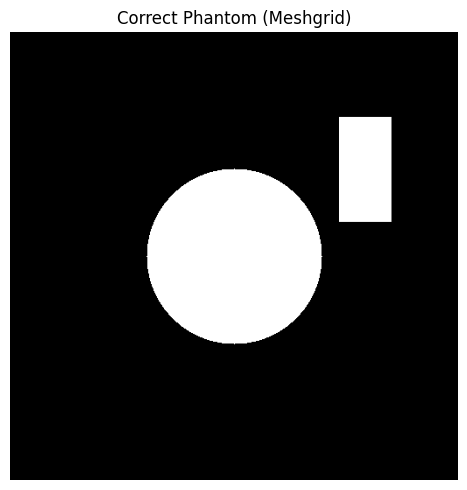

In [5]:
import numpy as np
import matplotlib.pyplot as plt

img_size = 512
f = np.zeros((img_size, img_size), dtype=np.float32)

# Create centered coordinate grid
x = np.arange(img_size) - img_size // 2
y = np.arange(img_size) - img_size // 2
xx, yy = np.meshgrid(x, y)

# Circle mask
circle_radius = 100
circle_mask = xx**2 + yy**2 <= circle_radius**2

rect_mask = (
    (xx >= 120) & (xx < 180) &   # x: right of center
    (yy <= -40) & (yy > -160)    # y: flipped from OpenCV
)

# Apply masks
f[circle_mask | rect_mask] = 1.0

# Plot
plt.figure(figsize=(5, 5))
plt.imshow(f, cmap='gray', origin='upper')  # 'upper' to match OpenCV style
plt.axis('off')
plt.title('Correct Phantom (Meshgrid)')
plt.tight_layout()
plt.show()


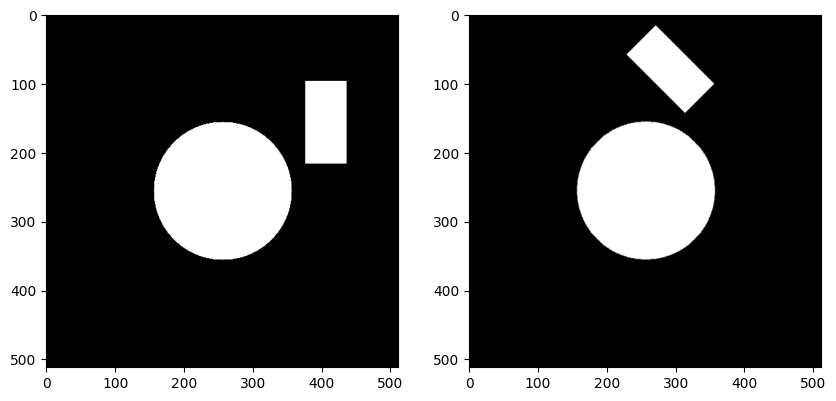

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(f, cmap="gray")
ax[1].imshow(rotate(f, 45), cmap="gray")
plt.show()

In [7]:
theta_deg = np.arange(0, 180, 180 / 1000)
thetas_rad = theta_deg * np.pi / 180
rs = np.arange(-f.shape[0] // 2, f.shape[0] // 2)
dtheta = np.diff(thetas_rad)[0] # all the diff's are the same
dr = np.diff(rs)[0]
rotations = np.array([rotate(f, theta) for theta in theta_deg]) # we now have 180 oriantations of the imgae

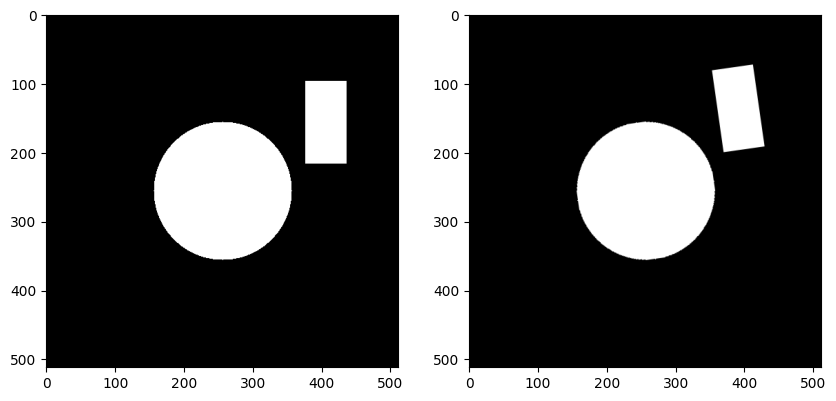

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(rotations[0], cmap="gray")
ax[1].imshow(rotations[45], cmap="gray")
plt.show()

In [9]:
rotations.shape

(1000, 512, 512)

In [10]:
p = np.array([rotation.sum(axis=0) * dr for rotation in rotations]).T
p.shape

(512, 1000)

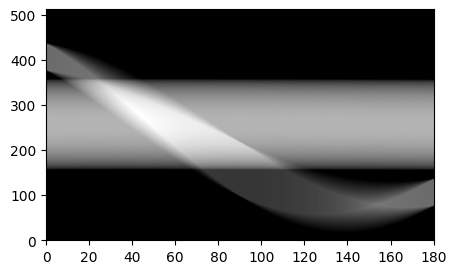

In [11]:
fig, ax = plt.subplots(figsize=(5, 3))

ax.imshow(p, cmap="gray", aspect='auto', origin='lower', extent=(0, 180, 0, 512))                             
plt.show()

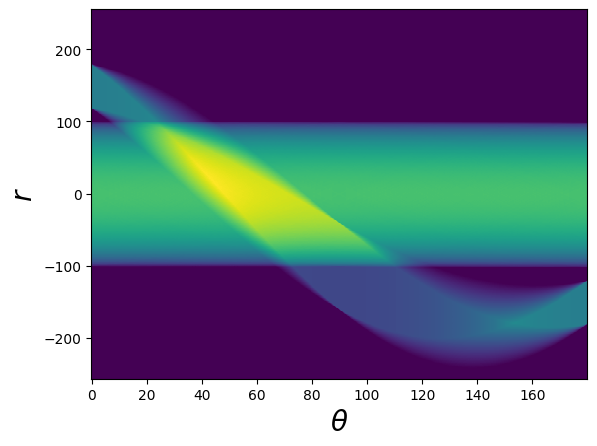

In [12]:
plt.pcolor(theta_deg, rs, p, shading='auto')
plt.xlabel(r'$\theta$', fontsize=20)
plt.ylabel('$r$', fontsize=20)
plt.show()

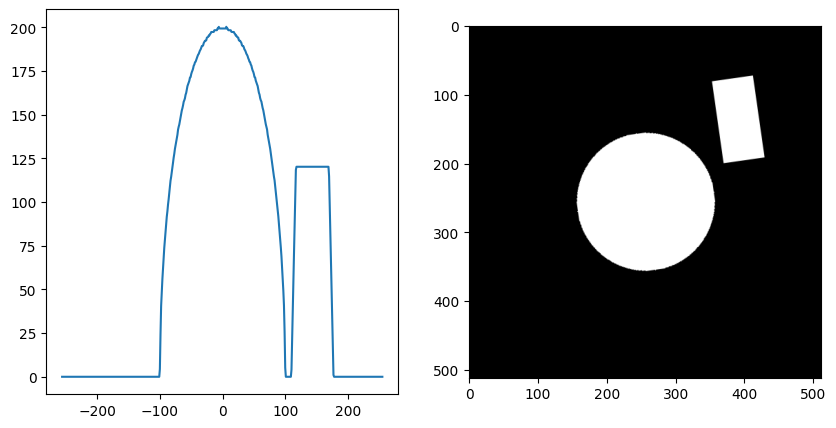

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(rs, p[:, 19])       
ax[1].imshow(rotations[45], cmap="gray")
plt.show()

In [14]:
# Interpulating on p to be able to back project
p_interp = RectBivariateSpline(rs, thetas_rad, p)

In [15]:
# instead of taking alot of projections I can thetas_rad[0:5] for example to see the progression
def get_fbp(x, y):
    return p_interp(x * np.cos(thetas_rad) + y * np.sin(thetas_rad), thetas_rad, grid=False).sum() * dtheta

FBP = np.vectorize(get_fbp)(xx, yy)

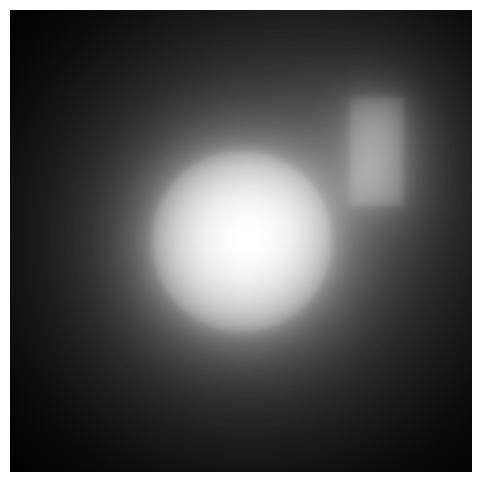

In [16]:
plt.figure(figsize=(6,6))
plt.imshow(FBP, cmap="gray")
plt.axis("off")
# plt.savefig(save_here + "simple_bp1000_1000.pdf", format='pdf', bbox_inches='tight', pad_inches=0)
plt.show()

In [17]:
p.shape

(512, 1000)

In [18]:
P = fft(p, axis=0) # fft on the coordinate for each different angle theta
nu = np.fft.fftfreq(P.shape[0], d=dr)

In [19]:
P_filtered = P.T * np.abs(nu)
P_filtered = P_filtered.T
p_filtered = np.real(ifft(P_filtered, axis=0))

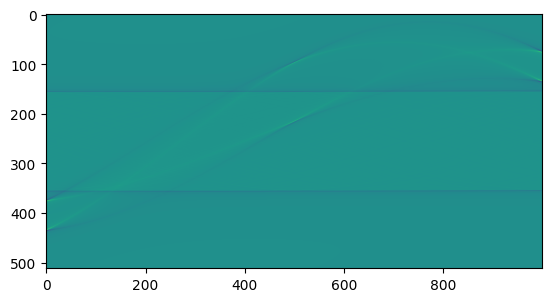

In [20]:
plt.imshow(p_filtered)

In [21]:
p_filtered_interp = RectBivariateSpline(rs, thetas_rad, p_filtered)

In [22]:
def get_f(x, y):
    return p_filtered_interp(x * np.cos(thetas_rad) + y * np.sin(thetas_rad), thetas_rad, grid=False).sum() * dtheta

f_recon = np.vectorize(get_f)(xx, yy)

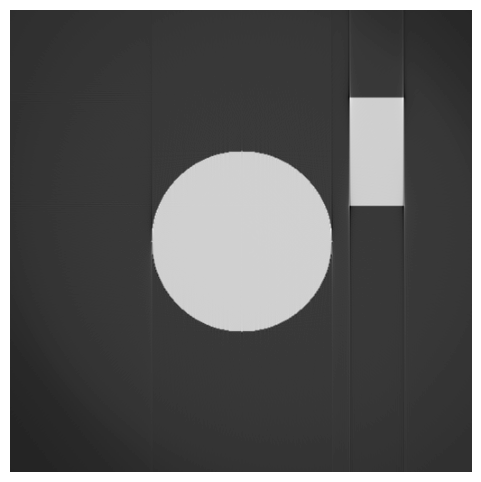

In [23]:
plt.figure(figsize=(6,6))
plt.imshow(f_recon, cmap="gray")
plt.axis("off")
plt.savefig(save_here + "filtered_bp1000_1000.png", format='png', bbox_inches='tight', pad_inches=0)
plt.show()